In [67]:
import numpy as np
import keras
from keras import layers, optimizers
from keras.callbacks import EarlyStopping
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from keras import layers, regularizers
from keras.layers import BatchNormalization, LeakyReLU, Dropout, InputLayer

# === Utils Functions ===
def dm2comp(dm):
    '''Extract weights and vectors from a density matrix.'''
    return dm[:, :, 0], dm[:, :, 1:]

def pure2dm(psi):
    '''Construct pure-state density matrix from feature vectors.'''
    ones = keras.ops.ones_like(psi[:, 0:1])
    return keras.ops.concatenate((ones[:, np.newaxis, :], psi[:, np.newaxis, :]), axis=2)

def dm_rbf_loglik(x, dm, sigma):
    '''Log-likelihood under an RBF-kernel density matrix.'''
    d = keras.ops.shape(x)[-1]
    w, v = dm2comp(dm)
    dist = keras.ops.sum((x[:, np.newaxis, :] - v)**2, axis=-1)
    ll = keras.ops.log(
        keras.ops.einsum('...i,...i->...', w,
                        keras.ops.exp(-dist / (2 * sigma**2))**2) + 1e-12
    )
    coeff = d * keras.ops.log(sigma + 1e-12) + d * np.log(np.pi) / 2
    return ll - coeff

def dm_rbf_expectation(dm):
    '''Expectation under an RBF-kernel density matrix.'''
    w, v = dm2comp(dm)
    return keras.ops.einsum('...i,...ij->...j', w, v)

def dm_rbf_variance(dm, sigma):
    '''Variance trace under an RBF-kernel density matrix.'''
    sigma_adj = sigma / keras.ops.sqrt(2)
    w, v = dm2comp(dm)
    d = keras.ops.shape(v)[-1]
    sq_norms = keras.ops.sum(v**2, axis=-1)
    w_sq = keras.ops.einsum('...i,...i->...', w, sq_norms)
    means = keras.ops.einsum('...i,...ij->...j', w, v)
    sq_means = keras.ops.sum(means**2, axis=-1)
    return (w_sq - sq_means) + d * (sigma_adj**2)

def gauss_entropy_lb(d, sigma):
    '''Entropy lower bound of Gaussian mixture.'''
    return (d/2.0) * (1.0 + keras.ops.log(2.0 * np.pi * (sigma**2)))

def l1_loss(vals):
    '''L1 regularization on normalized activations/components.'''
    b = keras.ops.cast(keras.ops.shape(vals)[0], dtype=keras.float32)
    vals_n = keras.utils.normalize(vals, order=2, axis=1)
    return keras.ops.sum(keras.ops.abs(vals_n)) / b



In [68]:
# === Kernel Layers ===
class RBFKernelLayer(keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.sigma = self.add_weight(shape=(), initializer=keras.initializers.Constant(sigma), trainable=trainable)
        self.dim = dim
        self.min_sigma = min_sigma

    def call(self, A, B):
        sA = keras.ops.sum(A**2, axis=-1)[..., np.newaxis]
        sB = keras.ops.sum(B**2, axis=-1)[np.newaxis, np.newaxis, :]
        Af = keras.ops.reshape(A, [-1, keras.ops.shape(A)[2]])
        AB = keras.ops.matmul(Af, keras.ops.transpose(B))
        AB = keras.ops.reshape(AB, [keras.ops.shape(A)[0], keras.ops.shape(A)[1], keras.ops.shape(B)[0]])
        dist2 = keras.ops.clip(sA + sB - 2.*AB, 0., np.inf)
        self.sigma.assign(keras.ops.clip(self.sigma, self.min_sigma, np.inf))
        return keras.ops.exp(-dist2 / (2.*self.sigma**2))

    def log_weight(self):
        sc = keras.ops.clip(self.sigma, self.min_sigma, np.inf)
        return -self.dim * keras.ops.log(sc + 1e-12) - self.dim * np.log(4 * np.pi)

class KDMLayer(keras.layers.Layer):
    def __init__(self, kernel, dim_x, dim_y, x_train=True, y_train=True, w_train=True,
                 n_comp=0, l1_x=0., l1_y=0., l1_act=0., generative=0., **kwargs):
        super().__init__(**kwargs)
        self.kernel, self.dim_x, self.dim_y = kernel, dim_x, dim_y
        self.x_train, self.y_train, self.w_train = x_train, y_train, w_train
        self.n_comp, self.l1_x, self.l1_y, self.l1_act, self.generative = (
            n_comp, l1_x, l1_y, l1_act, generative)
        self.c_x = self.add_weight(shape=(n_comp, dim_x), initializer=keras.initializers.random_normal(), trainable=x_train)
        self.c_y = self.add_weight(shape=(n_comp, dim_y), initializer=keras.initializers.Constant(np.sqrt(1./dim_y)), trainable=y_train)
        self.c_w = self.add_weight(shape=(n_comp,), initializer=keras.initializers.constant(1./n_comp), trainable=w_train)
        self.eps = 1e-12

    def call(self, inputs):
        if self.l1_x: self.add_loss(self.l1_x * l1_loss(self.c_x))
        if self.l1_y: self.add_loss(self.l1_y * l1_loss(self.c_y))
        cw = keras.ops.abs(self.c_w)
        cw /= keras.ops.clip(keras.ops.sum(cw), self.eps, np.inf)
        in_w, in_v = inputs[...,0], inputs[...,1:]
        out_vw = self.kernel(in_v, self.c_x)
        out_w = cw[np.newaxis,np.newaxis,:] * keras.ops.square(out_vw)
        if self.generative:
            proj = keras.ops.einsum('...i,...ij->...', in_w, out_w)
            logp = keras.ops.log(proj + self.eps) + self.kernel.log_weight()
            self.add_loss(-self.generative * keras.ops.mean(logp))
        out_w = keras.ops.maximum(out_w, self.eps)
        out_w = out_w / keras.ops.sum(out_w, axis=2, keepdims=True)
        out_w = keras.ops.einsum('...i,...ij->...j', in_w, out_w)
        if self.l1_act: self.add_loss(self.l1_act * l1_loss(out_w))
        out_w = out_w[..., np.newaxis]
        b = keras.ops.shape(out_w)[0]
        out_y = keras.ops.broadcast_to(self.c_y[np.newaxis,...], [b, self.n_comp, self.dim_y])
        return keras.ops.concatenate((out_w, out_y), axis=2)

    def get_config(self):
        return {**super().get_config(), 'dim_x':self.dim_x, 'dim_y':self.dim_y, 'n_comp':self.n_comp}

class KDMRegressModel(keras.Model):
    def __init__(self, encoded_size, dim_y, encoder, n_comp,
                 sigma_x=0.1, min_sigma_x=1e-3, sigma_y=0.1, min_sigma_y=1e-3,
                 x_train=True, y_train=True, w_train=True,
                 generative=0., entropy_reg_x=0.,
                 sigma_x_trainable=True, sigma_y_trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.dim_y, self.encoded_size, self.entropy_reg_x = dim_y, encoded_size, entropy_reg_x
        self.n_comp = n_comp
        if generative>0: encoder.trainable=False
        self.kernel = RBFKernelLayer(sigma_x, encoded_size, sigma_x_trainable, min_sigma_x)
        self.kdm = KDMLayer(self.kernel, encoded_size, dim_y,
                             x_train, y_train, w_train,
                             n_comp, generative=generative)
        self.sigma_y = self.add_weight(shape=(), initializer=keras.initializers.constant(sigma_y), trainable=sigma_y_trainable)
        self.min_sigma_y = min_sigma_y

    def call(self, x):
        rho_x = pure2dm(self.encoder(x))
        rho_y = self.kdm(rho_x)
        self.sigma_y.assign(keras.ops.clip(self.sigma_y, self.min_sigma_y, np.inf))
        return rho_y

    def predict_reg(self, x, **kwargs):
        rho_y = self.predict(x, **kwargs)
        return (keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y)),
                keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, self.sigma_y)))

    def get_sigmas(self):
        return (keras.ops.convert_to_numpy(self.kernel.sigma), keras.ops.convert_to_numpy(self.sigma_y))

    def init_components(self, sx, sy, init_sigma=False, sigma_mult=1):
        enc = self.encoder.predict(sx)
        if init_sigma:
            d,_ = NearestNeighbors(n_neighbors=3).fit(keras.ops.convert_to_numpy(enc)).kneighbors(keras.ops.convert_to_numpy(enc))
            self.kernel.sigma.assign(d[:,2].mean()*sigma_mult)
        self.kdm.c_x.assign(enc)
        self.kdm.c_y.assign(sy)
        self.kdm.c_w.assign(keras.ops.ones((self.n_comp,))/self.n_comp)

    def loglik(self, y_true, y_pred):
        return -keras.ops.mean(dm_rbf_loglik(y_true, y_pred, self.sigma_y))

    def compute_loss(self, x, y, yp, sw, training=True):
        loss = self.loglik(y, yp)
        if self.losses: loss += keras.ops.sum(self.losses)
        if self.entropy_reg_x:
            loss -= self.entropy_reg_x * gauss_entropy_lb(self.encoded_size, self.kernel.sigma/keras.ops.sqrt(2))
        return loss



In [70]:
# === Load and Prepare Diabetes Data ===
X_orig, y_orig = load_diabetes(return_X_y=True)
y_orig = y_orig.reshape(-1,1)
scaler_X, scaler_y = StandardScaler(), StandardScaler()
X = scaler_X.fit_transform(X_orig)
y = scaler_y.fit_transform(y_orig)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [79]:
# === Model Setup with MLP encoder ===
encoded_size, dim_y = x_train.shape[1], y_train.shape[1]
encoder = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(encoded_size,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(encoded_size, activation='linear'),
])
n_comp = 50

model = KDMRegressModel(
    encoded_size=encoded_size,
    dim_y=dim_y,
    encoder=encoder,
    n_comp=n_comp,
    sigma_x=0.5,
    min_sigma_x=1e-3,
    sigma_y=0.3,
    min_sigma_y=1e-3,
    generative=0.0,
    sigma_x_trainable=True,
    sigma_y_trainable=True
)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4))

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)

# Initialize KDM components without replacement
idx = np.random.RandomState(42).choice(x_train.shape[0], size=n_comp, replace=False)
model.init_components(x_train[idx], y_train[idx], init_sigma=False)

# Train
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 1.3198 - val_loss: 1.2771
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2507 - val_loss: 1.2228
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2950 - val_loss: 1.1814
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1788 - val_loss: 1.1553
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2353 - val_loss: 1.1386
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1693 - val_loss: 1.1245
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1276 - val_loss: 1.1129
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0916 - val_loss: 1.1054
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1047 - val_loss: 1.0989
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0484 - val_loss: 1.0944
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1086 - val_loss: 1.0883
Epoch 12/50
10/10 ━━━━━━━━━━━━

In [80]:
# === Sigmas Learned ===
sx, sy = model.get_sigmas()
print(f"Learned sigma_x: {sx:.4f}, sigma_y: {sy:.4f}")


Learned sigma_x: 0.4869, sigma_y: 0.3012


In [81]:


# === Predictions & Metrics ===
y_pred, y_var = model.predict_reg(x_test)
yp_res = scaler_y.inverse_transform(y_pred)
yt_res = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(yt_res, yp_res)
r2 = r2_score(yt_res, yp_res)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
Test MSE: 2864.3933
Test R2: 0.4594


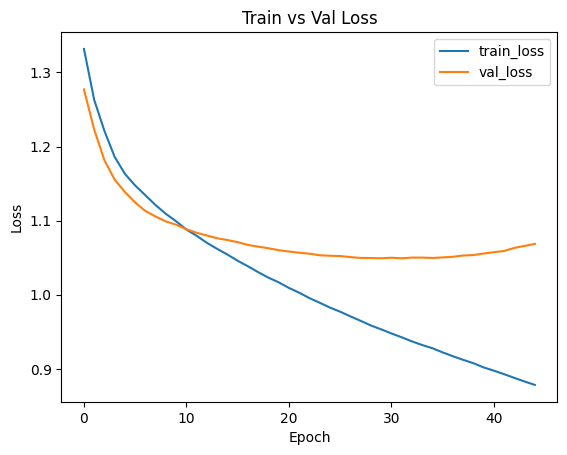

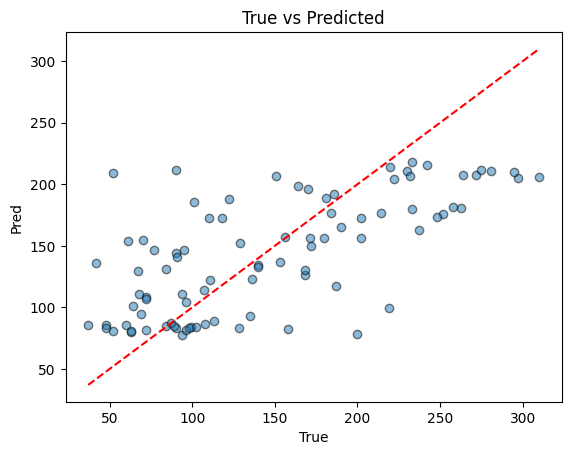

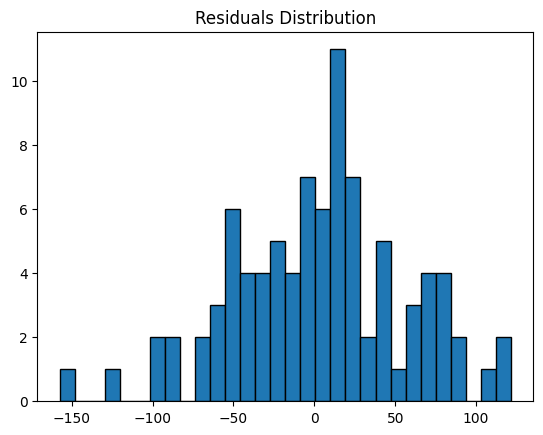

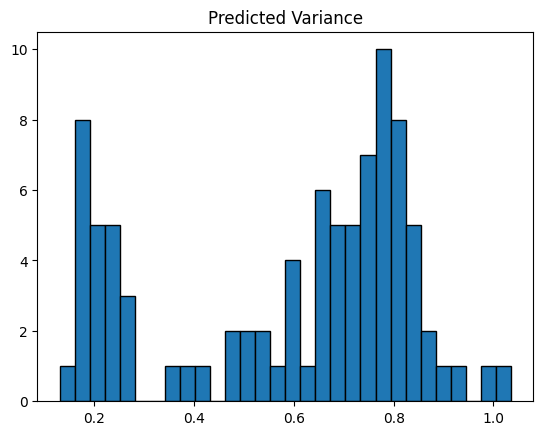

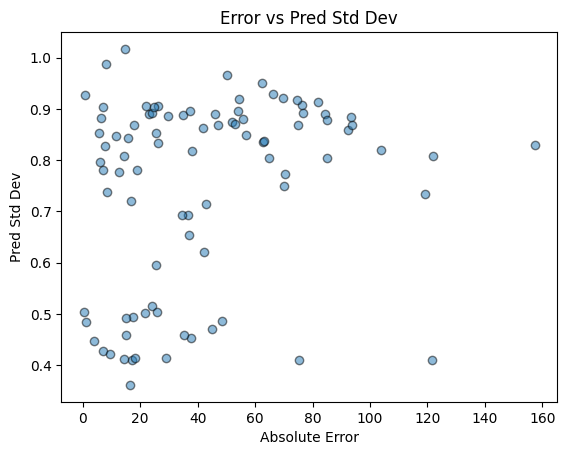

In [83]:
# === Visualizations ===
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train vs Val Loss'); plt.legend(); plt.show()

plt.figure()
plt.scatter(yt_res, yp_res, alpha=0.5, edgecolor='k')
lims=[yt_res.min(), yt_res.max()]; plt.plot(lims, lims, 'r--')
plt.xlabel('True'); plt.ylabel('Pred'); plt.title('True vs Predicted'); plt.show()

res = yt_res - yp_res
plt.figure(); plt.hist(res.flatten(), bins=30, edgecolor='k'); plt.title('Residuals Distribution'); plt.show()

plt.figure(); plt.hist(y_var.flatten(), bins=30, edgecolor='k'); plt.title('Predicted Variance'); plt.show()

plt.figure()
plt.scatter(np.abs(res.flatten()), np.sqrt(y_var.flatten()), alpha=0.5, edgecolor='k')
plt.xlabel('Absolute Error'); plt.ylabel('Pred Std Dev'); plt.title('Error vs Pred Std Dev'); plt.show()
